## Initializations

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time

#GLOBAL Variables:
grain = 100
t_1 = 1

#Change these in code as seen fit
t_3 = 0
q = 5

#Conventions:
p = 1
n_phi = p/q #phi in the paper

#Note we take a=1 (lattice constant)

Similarly to the Hofstadter model in a magnetic field with strength B in the Landau gauge as

$$ \textbf{A} = \begin{bmatrix} 0 \\ Bx \\ 0 \end{bmatrix} \phantom{h} \textrm{ such that  } \phantom{h} \nabla \times A = B.$$

We define the Peierls phase as: 

$$ \theta_{ij} = \frac{2\pi}{\phi_0} \int_i^j A \cdot dl = 2\pi n_{\phi}(y_j-y_i)(x_i+\frac{x_j-x_i}{2})$$

Thus, we can now take a look at the Zero Quadratic Model Hamiltonian:

$$
H = -t_1 \sum_{<ij>_1} e^{\mathrm{i}\theta_{ij}} c^\dagger_i c_j 
- t_3 \sum_{<ij>_3} e^{\mathrm{i}\theta_{ij}} c^\dagger_i c_j 
+  \frac{V}{2} \sum_{<ij>_1} \rho_i \rho_j
+ \mathrm{H.c.},
$$


(Here we look at the model without interactions so set $V=0$.
Attempting to determine the band structure, we look at the eigenvalue equation $H\Psi_{mn} = E \Psi_{mn}$ in momentum space.

Thus, we use the ansatz $\Psi_{mn} = e^{ik_xm}e^{ik_yn}\psi_m$ for $0 \leq k_y < 2\pi$ and $0 \leq k_x q <2 \pi$ due to boundary conditions, we also see that $\Psi_{m, n+1} = \Psi_{m, n}$ and $\Psi_{m+q, n} = \Psi_{m, n}$.

Substituting the Peierls phase as well as our wave ansatz acting on our eigenvalue equation, we get (skipping simplifications):


$$ E \psi_m = C^* \psi_{m-2} + B^* \psi_{m-1} + A \psi_m + B\psi_{m+1} + C \psi_{m+2}$$

for $C = -t_3 e^{i2k_x}$, $B = -t_1 e^{ik_x}-t_3 e^{i2\pi n_\phi (m+\frac{1}{2})})e^{ik_x}e^{ik_y}$ and $A = -2(t_1\cos(2\pi n_\phi m +k_y)+t_3\cos(4\pi n_\phi m +k_y))$

From here, we can write our Hamiltonian in a matrix form and diagonalize this to find the band structure using Python:

In [2]:
def H(q, kx, ky): #Find the 2d-Hamiltonian matrix for some q-value at (k_x, k_y) in momentum space
    n_phi = p/q
    def A(m, ky):
        return -2*(t_1*np.cos(2*np.pi*n_phi*m + ky)+t_3*np.cos(4*np.pi*n_phi*m+2*ky))
    def B(m, kx, ky):
        return -t_1*np.exp(1j*kx)
        #return t_1*np.exp(1j*k_x)+t_3*np.exp(1j*2*np.pi*n_phi*(m+1/2))*np.exp(1j*k_x)*np.exp(1j*k_y)
    def C(kx):
        return -t_3 * np.exp(1j*2*kx)
    
    B_arr_temp = np.diag(np.array([B(i,kx,ky) for i in range(q)]))
    C_arr_temp = np.diag(np.array([C(kx) for i in range(q)]))
    
    A_arr = np.diag(np.array([A(i,ky) for i in range(q)]))
    B_arr = np.roll(B_arr_temp, 1, axis = 1)
    Bc_arr = np.conjugate(np.roll(B_arr_temp, 1, axis = 0))
    C_arr = np.roll(C_arr_temp, 2, axis = 1)
    Cc_arr = np.conjugate(np.roll(C_arr_temp, 2, axis = 0))
    
    return A_arr+B_arr+Bc_arr+C_arr+Cc_arr


def H_eigenvectors(q):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    eigenvectors_arr = np.empty((q, len(k_x), len(k_y), q),dtype = "complex_")
    for i, kx in enumerate(k_x):
        for j, ky in enumerate(k_y):
            matrix = H(q, kx, ky)
            assert(np.all(0 == (matrix - np.conj(matrix.T))))
            eigenvalues, eigenvectors = np.linalg.eigh(matrix)
            for a in range(q):
                eigenvectors_arr[a, i, j, :] = eigenvectors[:, a]
    return eigenvectors_arr

def H_eigenvalues(q):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    eigenvalues_arr = np.empty((q, len(k_x), len(k_y)))
    for i, kx in enumerate(k_x):
        for j, ky in enumerate(k_y):
            matrix = H(q, kx, ky)
            assert(np.all(0 == (matrix - np.conj(matrix.T))))
            eigenvalues, eigenvectors = np.linalg.eigh(matrix)
            for a in range(q):
                eigenvalues_arr[a, i, j] = eigenvalues[a]
    return eigenvalues_arr

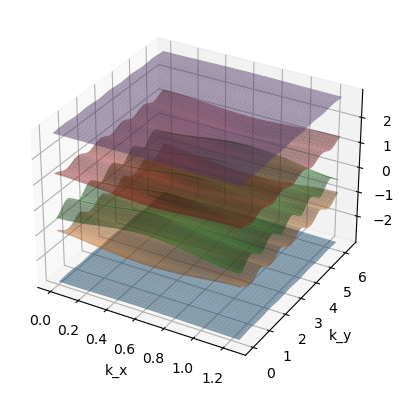

In [3]:
q=5
eigenvalues_arr = H_eigenvalues(q)
eigenvectors_arr = H_eigenvectors(q)

k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
K_x, K_y = np.meshgrid(k_x, k_y, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for a in range(q):
    ax.plot_surface(K_x, K_y, eigenvalues_arr[a], alpha=0.5)

ax.set_xlabel('k_x')
ax.set_ylabel('k_y')
ax.set_zlabel('Energy (t)')
plt.savefig('band_structure')
plt.show()

## Chern number


Computing chern numbers, we have $$c_\mu = \frac{1}{i 2\pi}\int_{\textrm{FBZ}} \langle \frac{\partial\psi_\mu(k)}{\partial x}|\frac{\partial\psi_\mu(k)}{\partial y} \rangle - \langle \frac{\partial\psi_\mu(k)}{\partial y}|\frac{\partial\psi_\mu(k)}{\partial x} \rangle d^2 k$$

For some reason this was not working numerically. From (https://opg.optica.org/oe/fulltext.cfm?uri=oe-28-4-4638&id=426551), using a different computation scheme as such, we get our answer:




$$c_n  = \frac{1}{2 \pi} \int_{\textrm{BZ}} \mathbf{F}_{n}(\mathbf{k}) \textrm{d} \mathbf{k}\\ $$


$$c_\mu = \frac{1}{i 2\pi}\int_{\textrm{FBZ}} \partial_x \langle \psi_\mu(k)|\partial_y \psi_\mu(k) \rangle - \partial_y \langle\psi_\mu(k)|\partial_x\psi_\mu(k) \rangle d^2 k$$


substituting for derivatives using a first order finite difference and simplifying by approximating through link variables at small values and Taylor expanding, we get:


$$ {= \frac{1}{2 \pi} \sum_{\mathbf{k}\in\textrm{BZ}} \operatorname{Im} \ln\left[{ U_{\mathbf{k}_1 \rightarrow \mathbf{k}_2}^{(n)} U_{\mathbf{k}_2 \rightarrow \mathbf{k}_3 }^{(n)} U_{\mathbf{k}_3\rightarrow \mathbf{k}_4}^{(n)} U_{\mathbf{k}_4 \rightarrow \mathbf{k}_1}^{(n)} }\right]}
$$



with $U_{\mathbf {k}_{\alpha } \rightarrow \mathbf {k}_{\beta }}^{(n)} \equiv \frac {\left \langle \mathbf {u}_{n,e,\mathbf {k}_{\alpha }} | \mathbf {u}_{n,e, \mathbf {k}_{\beta }}\right \rangle }{\left |\left \langle \mathbf {u}_{n,e,\mathbf {k}_{\alpha }} | \mathbf {u}_{n,e, \mathbf {k}_{\beta }}\right \rangle \right |}$.




In [4]:
def chern_number(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    chern_sum = 0
    eigenvectors_temp = H_eigenvectors(q)
    for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            chern_sum += chern_number_helper(eigenvectors_temp, i, xi, yi)
    return (1/ (2 * np.pi)) * chern_sum

def chern_number_helper(eigenvectors_temp, i, x, y):
    psi_1 = eigenvectors_temp[i, x % len(k_x), y % len(k_y), :]
    psi_2 = eigenvectors_temp[i, (x + 1) % len(k_x), y % len(k_y), :]
    psi_3 = eigenvectors_temp[i, (x+1) % len(k_x), (y + 1) % len(k_y), :]
    psi_4 = eigenvectors_temp[i, x % len(k_x), (y + 1) % len(k_y), :]

    U12 = np.vdot(psi_1, psi_2)/np.abs(np.vdot(psi_1, psi_2))
    U23 = np.vdot(psi_2, psi_3)/np.abs(np.vdot(psi_2, psi_3))
    U34 = np.vdot(psi_3, psi_4)/np.abs(np.vdot(psi_3, psi_4))
    U41 = np.vdot(psi_4, psi_1)/np.abs(np.vdot(psi_4, psi_1))

    return -1*np.imag(np.log(U12*U23*U34*U41))

q=5
print([chern_number(q, i) for i in range(q)])

[1.0000000000000033, 0.999999999999999, -4.000000000000009, 1.0000000000000033, 0.9999999999999962]


## Quantum Geometric Tensor Calculations

Note using finite differences we can write

$$
\mathcal{R}_{ab} = \langle \partial_{k_a} u^s (k) | \partial_{k_b}  u^s (k) \rangle - \langle \partial_{k_a} u^s (k) | u^s (k) \rangle \langle u^s (k) | \partial_{k_b} u^s (k) \rangle
$$

into: 

$$
\mathcal{R}_{ab} = \frac{1}{\Delta a \Delta b}(\langle u^s (k+\Delta k_a) | u^s (k+\Delta k_b) \rangle - \langle u^s (k+\Delta k_a) | u^s (k) \rangle \langle u^s (k) | u^s (k+\Delta k_b) \rangle
$$




In [5]:
def qgt(H_eigenvectors_arr, i, ikx, iky): #Outputs quantum geometric tensor in 2d matrix form (xy component indexed as [0,1])
    dx, dy = (k_x[1]-k_x[0])/1000, (k_y[1]-k_y[0])/1000
    eig_0 = H_eigenvectors_arr[0][i, ikx % len(k_x), iky % len(k_y), :]
    eig_x = H_eigenvectors_arr[1][i, ikx % len(k_x), iky % len(k_y), :]
    eig_y = H_eigenvectors_arr[2][i, ikx % len(k_x), iky % len(k_y), :]
    eigs = {}
    eigs.update({"x": eig_x})
    eigs.update({"y": eig_y})
    grad = {}
    grad.update({"x": (eig_x-eig_0)/dx})
    grad.update({"y": (eig_y-eig_0)/dy})
    #dx = {}
    #dx.update({"x": (k_x[1] - k_x[0])})
    #dx.update({"y": (k_y[1] - k_y[0])})
    return np.array([[np.vdot(grad[u], grad[v]) - np.vdot(grad[u], eig_0)*np.vdot(eig_0, grad[v]) for u in ["x", "y"]] for v in ["x", "y"]])
    
def fs_metric(H_eigenvectors_arr, i, ikx, iky): #Outputs the Fubini-Study metric in 2d matrix form (just the real part)
    return np.real(qgt(H_eigenvectors_arr, i, ikx, iky))

def berry_curv(H_eigenvectors_arr, i, ikx, iky): #Outputs Berry Curvature in 2d matrix form
    return -2*np.imag(qgt(H_eigenvectors_arr, i, ikx , iky))

##### Check for chern number calculation (note converges very slowly and only has close results at grain ~ 1000

In [6]:
def chern_number_qgt(q, i): #Chern number calculation using the quantum geometric tensor
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    H_eigenvectors_arr_0 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi, grain)
    H_eigenvectors_arr_1 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)+tdy
    H_eigenvectors_arr_2 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    H_eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    chern_sum = 0
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            chern_sum += berry_curv(H_eigenvectors_arr, i, xi, yi)[1,0]*dx*dy
    return (1/ (2 * np.pi)) * chern_sum

In [7]:
#Test for chern_number_qgt
q=5
print([chern_number_qgt(q, i) for i in range(q)])

NameError: name 'H_eigenvectors2' is not defined

### < TISM > and < DISM > functions

In [8]:
def TISM(H_eigenvectors_arr, i, xi, yi): #Finds TISM at some xi and yi indices in k_x and k_y respectively
    return np.trace(fs_metric(H_eigenvectors_arr, i, xi, yi)) - np.abs(berry_curv(H_eigenvectors_arr, i ,xi ,yi)[0,1])

def DISM(H_eigenvectors_arr, i, xi, yi): #Finds TISM at some xi and yi indices in k_x and k_y respectively
    return np.linalg.det(fs_metric(H_eigenvectors_arr, i, xi, yi)) - 1/4*np.abs(berry_curv(H_eigenvectors_arr, i, xi, yi)[0,1])

def TISM_int(q, i): #INTEGRATES TISM over the Magnetic Brouillon Zone
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    H_temp = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    tisms = np.empty((len(k_x)-1, len(k_y)-1))
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                tisms[xi][yi] = (np.trace(fs_metric(H_temp, 0, xi, yi)) - np.abs(berry_curv(H_temp, 0 ,xi ,yi)[0,1]))
    return np.sum(tisms)*dx*dy/(2*np.pi)

#Note the following functions are also affected by the inconsistency with boundary conditions
def DISM_int(q, i, k_x, k_y): #Integrates the DISM over the Magnetic Brouillon Zone
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    H_temp = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    dism_sum = 0
    for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            dism_sum += np.linalg.det(fs_metric(H_eigenvectors_arr, i, xi, yi)) - 1/4*np.abs(berry_curv(H_eigenvectors_arr, i, xi, yi)[0,1])
    return dism_sum*dx*dy

In [9]:
def g_dev_int(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    temp = 0
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                temp += qgt(eigenvectors_arr, i, xi, 0)-qgt(eigenvectors_arr, i, 0, 0)
    return temp*dx*dy
def B_dev_int(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    temp = 0
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                temp += berry_curv(eigenvectors_arr, i, xi, 0) - berry_curv(eigenvectors_arr, i, 0, 0)
    return temp*dx*dy

def T_dev_int(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    temp = 0
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                temp += TISM(eigenvectors_arr, i, xi, 0) - TISM(eigenvectors_arr, i, 0, 0)
    return temp*dx*dy
def D_dev_int(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    tdx, tdy = (k_x[1] - k_x[0])/1000, (k_y[1] - k_y[0])/1000
    H_eigenvectors_arr_0 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_1 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain)+tdx, np.linspace(0, 2 * np.pi/q, grain))
    H_eigenvectors_arr_2 = H_eigenvectors2(q, np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi/q, grain)+tdy)
    eigenvectors_arr = np.array([H_eigenvectors_arr_0, H_eigenvectors_arr_1, H_eigenvectors_arr_2])
    n_phi = p/q
    temp = 0
    for xi in range(len(k_x)-1):
            for yi in range(len(k_y)-1):
                temp += DISM(eigenvectors_arr, i, xi, 0) - DISM(eigenvectors_arr, i, 0, 0)
    return temp*dx*dy

In [10]:
def g_rms_int(q, i):
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    temp = np.array([[None, None], [None, None]])
    eigenvectors_arr = H_eigenvectors(q)
    dev = 0
    temp = np.empty((len(k_x)-1))
    for xi in range(len(k_x)-1):
        temp[xi] = qgt(eigenvectors_arr, i, xi, 0)-qgt(eigenvectors_arr, i, 0, 0)
    for xi in range(len(k_x)-1):
        dev += (temp[xi])**2
    return np.sqrt(dev/(len(temp)))
def B_rms_int(q, i):
    eigenvectors_arr = H_eigenvectors(q)
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    dev = 0
    temp = np.empty((len(k_x)-1))
    for xi in range(len(k_x)-1):
        temp[xi] = berry_curv(eigenvectors_arr, i, xi, 0) - berry_curv(eigenvectors_arr, i, 0, 0)
    for xi in range(len(k_x)-1):
        dev += (temp[xi])**2
    return np.sqrt(dev/(len(temp)))

def T_rms_int(q, i):
    eigenvectors_arr = H_eigenvectors(q)
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    dev = 0
    temp = np.empty((len(k_x)-1))
    for xi in range(len(k_x)-1):
        temp[xi] =  TISM(eigenvectors_arr, i, xi, 0) - TISM(eigenvectors_arr, i, 0, 0)
    for xi in range(len(k_x)-1):
        dev += (temp[xi])**2
    return np.sqrt(dev/(len(temp)))
def D_rms_int(q, i):
    eigenvectors_arr = H_eigenvectors(q)
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
    temp = np.empty((len(k_x)-1))
    dev = 0
    for xi in range(len(k_x)-1):
        temp[xi] =  DISM(eigenvectors_arr, i, xi, 0) - DISM(eigenvectors_arr, i, 0, 0)
    for xi in range(len(k_x)-1):
        dev += (temp[xi])**2
    return np.sqrt(dev/(len(temp)))

### RMS

In [ ]:
#g
t_3 = 0
grain=100
q_vec = np.arange(1, 30, 1)
g_ave = []
for q in q_vec:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    g_ave.append(g_rms_int(q,0))
plt.scatter(q_vec, np.array(g_ave)[:,0,0], c = 'blue', s=10)
plt.yscale('log')
plt.figure()
plt.scatter(q_vec, np.abs(np.array(g_ave)[:,0,1]), c = 'red', s=10)
plt.yscale('log')
plt.figure()
plt.scatter(q_vec, np.array(g_ave)[:, 1,1], c = 'green', s=10)
plt.yscale('log')
plt.figure()
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 621


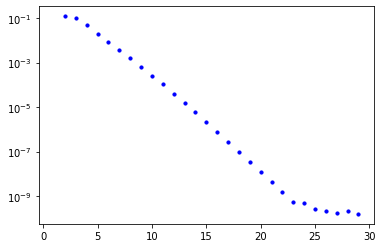

<Figure size 432x288 with 0 Axes>

In [19]:
T_ave = []
for q in q_vec:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    T_ave.append(T_rms_int(q,0))
plt.scatter(q_vec, np.array(T_ave), c = 'blue', s=10)
plt.yscale('log')
plt.figure()
plt.show()

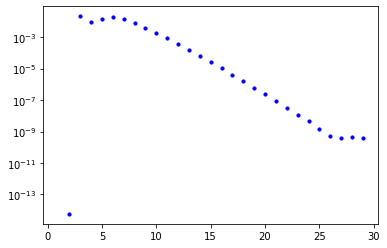

<Figure size 432x288 with 0 Axes>

In [20]:
D_ave = []
for q in q_vec:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    D_ave.append(D_rms_int(q,0))
plt.scatter(q_vec, np.array(D_ave), c = 'blue', s=10)
plt.yscale('log')
plt.figure()
plt.show()

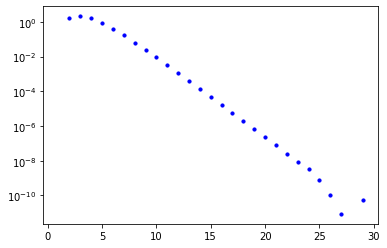

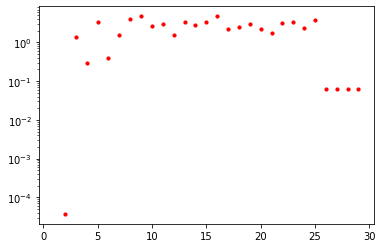

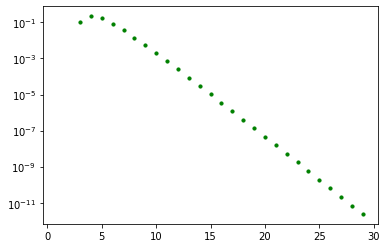

<Figure size 432x288 with 0 Axes>

In [31]:
#g
t_3 = 0
grain=100
q_vec = np.arange(1, 30, 1)
g_ave = []
for q in q_vec:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    g_ave.append(g_dev_int(q,0))
plt.scatter(q_vec, np.array(g_ave)[:,0,0], c = 'blue', s=10)
plt.yscale('log')
plt.figure()
plt.scatter(q_vec, np.abs(np.array(g_ave)[:,0,1]), c = 'red', s=10)
plt.yscale('log')
plt.figure()
plt.scatter(q_vec, np.array(g_ave)[:, 1,1], c = 'green', s=10)
plt.yscale('log')
plt.figure()
plt.show()

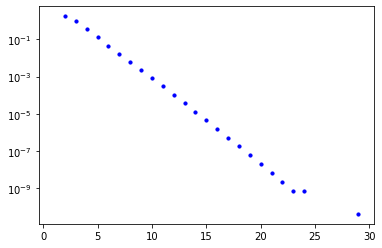

<Figure size 432x288 with 0 Axes>

In [36]:
T_ave = []
for q in q_vec:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    T_ave.append(T_dev_int(q,0))
plt.scatter(q_vec, np.array(T_ave), c = 'blue', s=10)
plt.yscale('log')
plt.figure()
plt.show()

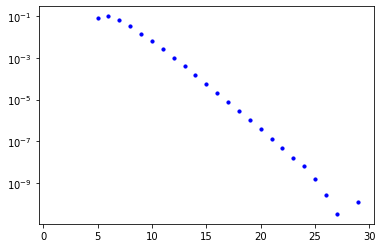

<Figure size 432x288 with 0 Axes>

In [37]:
D_ave = []
for q in q_vec:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    D_ave.append(D_dev_int(q,0))
plt.scatter(q_vec, np.array(D_ave), c = 'blue', s=10)
plt.yscale('log')
plt.figure()
plt.show()

### 3D Map of TISM over MBZ

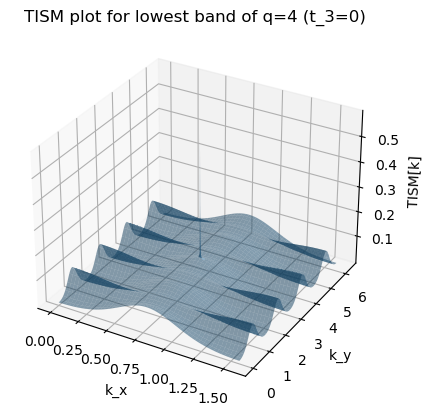

--- 80.79183411598206 seconds ---


In [12]:
#Gives a 3d mapping of TISM values give some kx and ky values over the MBZ
start_time = time.time()
q =4
t_3 = 0
grain=1000
k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
n_phi = p/q
H_eigenvectors_arr = H_eigenvectors(q)

tisms = np.empty((len(k_x)-1, len(k_y)-1))
for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            tisms[xi][yi] = (np.trace(fs_metric(H_eigenvectors_arr, 0, xi, yi)) 
                             - np.abs(berry_curv(H_eigenvectors_arr, 0 ,xi ,yi)[0,1]))
K_x, K_y = np.meshgrid(k_x[:-1], k_y[:-1], indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_x, K_y, tisms, alpha=0.5)

ax.set_title('TISM plot for lowest band of q={} (t_3=0)'.format(q))
ax.set_xlabel('k_x')
ax.set_ylabel('k_y')
ax.set_zlabel('TISM[k]')
plt.savefig('band_structure')
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
np.sum(tisms)*dx*dy/(2*np.pi)

0.08309923193915912

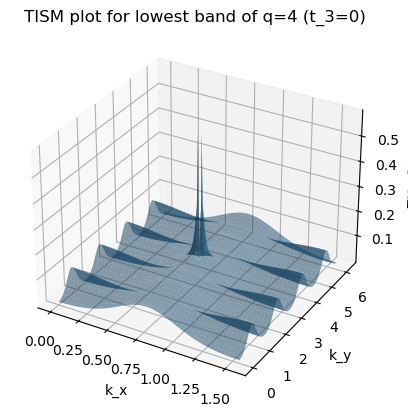

In [14]:
#Gives a 3d mapping of TISM values give some kx and ky values over the MBZ
q = 4
t_3 = 0
k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
n_phi = p/q
H_eigenvectors_arr = H_eigenvectors(q)

tisms = np.empty((len(k_x)-1, len(k_y)-1))
for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            tisms[xi][yi] = TISM(H_eigenvectors_arr, 0, xi, yi)
K_x, K_y = np.meshgrid(k_x[:-1], k_y[:-1], indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_x, K_y, tisms, alpha=0.5)

ax.set_title('TISM plot for lowest band of q={} (t_3=0)'.format(q))
ax.set_xlabel('k_x')
ax.set_ylabel('k_y')
ax.set_zlabel('TISM[k]')
plt.savefig('band_structure')
plt.show()

In [ ]:
np.sum(tisms)*dx*dy/(2*np.pi)

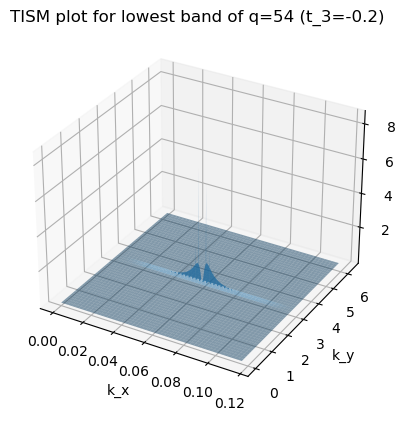

In [19]:
#Gives a 3d mapping of TISM values give some kx and ky values over the MBZ
q = 54
t_3 = 0
grain=1000
k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
dx, dy = (k_x[1] - k_x[0]), (k_y[1] - k_y[0])
n_phi = p/q
H_eigenvectors_arr = H_eigenvectors(q)

tisms = np.empty((len(k_x)-1, len(k_y)-1))
for xi in range(len(k_x)-1):
        for yi in range(len(k_y)-1):
            tisms[xi][yi] = TISM(H_eigenvectors_arr, 0, xi, yi)
K_x, K_y = np.meshgrid(k_x[:-1], k_y[:-1], indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_x, K_y, tisms, alpha=0.5)
ax.set_title('TISM plot for lowest band of q={} (t_3=-0.2)'.format(q))
ax.set_xlabel('k_x')
ax.set_ylabel('k_y')
ax.set_zlabel('TISM[k]')
plt.savefig('band_structure')
plt.show()

In [20]:
np.sum(tisms)*dx*dy/(2*np.pi)

0.0002564172030355483

In [22]:

print(TISM_int(4,0))

85.73720992767748


### <span style="color:red"> Note that the above plot has large values at the boundaries (this also decreases with a larger grain/finer discretization)
</span>




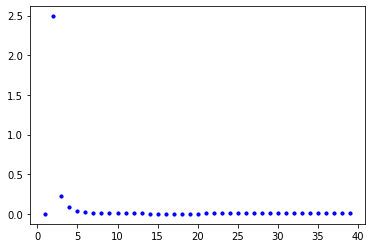

In [11]:
#Look at the first band (i=0) #avg function updated
t_3 = 0
grain=100
q_vec = np.arange(1, 40, 1)
tism_avg_points = []
for q in q_vec:
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tism_avg_points.append(TISM_int(q,0))
plt.scatter(q_vec, tism_avg_points, c = 'blue', s=10)
plt.show()

(Plot to show that q->inf, TISM ->0)

## Fig. 3 comparison  < TISM>

In [ ]:
q_arr = np.array([4, 6, 24, 54])
grid=100
for q in q_arr:
    n_phi = 1/q
    points = np.array([None, None])
    for t_temp in np.linspace(-0.25, 0, 20):
        t_3 = t_temp
        k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
        tism = np.array([t_3, TISM_int(q,0)])
        points = np.vstack((points, tism))
    plt.scatter(points[:, 0], points[:, 1], label = r"$\phi=1/{}$".format(q))
plt.legend()
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 622


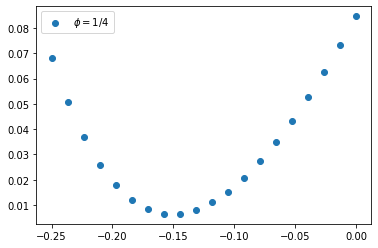

In [21]:
q =4
n_phi = 1/q
points = np.array([None, None])
for t_temp in np.linspace(-0.25, 0, 20):
    t_3 = t_temp
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tism = np.array([t_3, TISM_int(q,0)])
    points = np.vstack((points, tism))
plt.scatter(points[:, 0], points[:, 1], label = r"$\phi=1/{}$".format(q))
plt.legend()
plt.show()

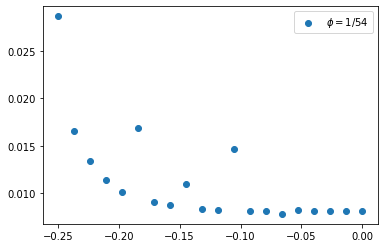

In [22]:
q = 54
n_phi = 1/q
points = np.array([None, None])
for t_temp in np.linspace(-0.25, 0, 20):
    t_3 = t_temp
    k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
    tism = np.array([t_3, TISM_int(q,0)])
    points = np.vstack((points, tism))
plt.scatter(points[:, 0], points[:, 1], label = r"$\phi=1/{}$".format(q))
plt.legend()
plt.show()

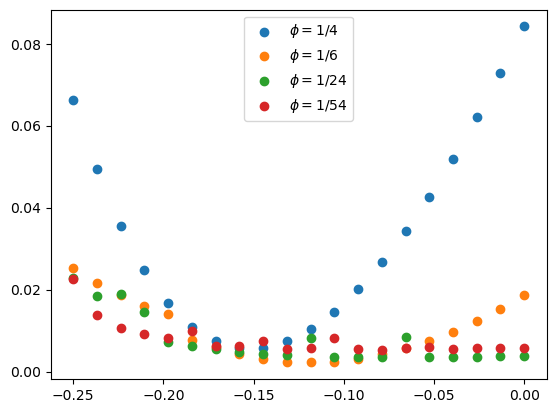

--- 264.1352369785309 seconds ---


In [13]:
start_time = time.time()
q_arr = np.array([4, 6, 24, 54])
grain=100
for q in q_arr:
    n_phi = 1/q
    points = np.array([None, None])
    for t_temp in np.linspace(-0.25, 0, 20):
        t_3 = t_temp
        k_x, k_y = np.linspace(0, 2 * np.pi/q, grain), np.linspace(0, 2 * np.pi, grain)
        tism = np.array([t_3, TISM_int_modified(q,0)])
        points = np.vstack((points, tism))
    plt.scatter(points[:, 0], points[:, 1], label = r"$\phi=1/{}$".format(q))
plt.legend()
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [23]:
#Try using automatic differentiation: python packages (jax)
#https://notebook.community/albi3ro/M4/Graduate/Chern-Number


# Etc.

## Hofstadter Butterfly

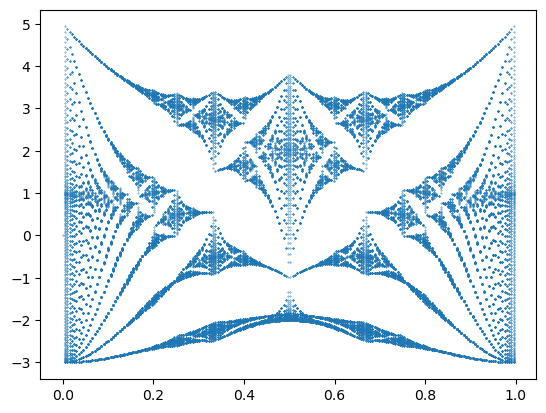

In [9]:
#For k=[0,0]
t_3=-1/4
q=199
points = np.array([0, 0])
for p in range(1,q):
    n_phi = p/q
    energies = np.linalg.eigvalsh(H(q, 0, 0)) #only use k = [0, 0]
    for e in energies:
        points = np.vstack((points, np.array([p/q, e])))
plt.scatter(points[:, 0], points[:, 1], s=0.1) #NOTE I PLOTTED THE FIGURE FLIPPED TO MATCH WITH FIGURE 2
plt.show()

p, q = p_org, q_org

In [23]:
print(np.shape(points[:,0]))
print(points[198,1])

(39403,)
4.8136440981419675


## Wilson Loop

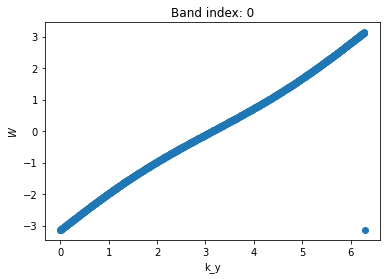

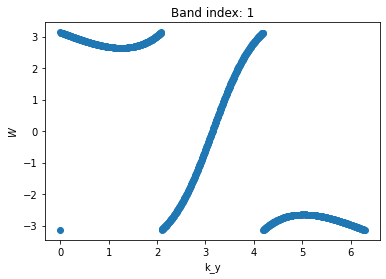

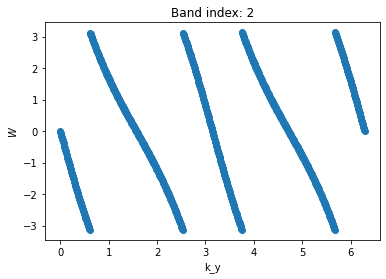

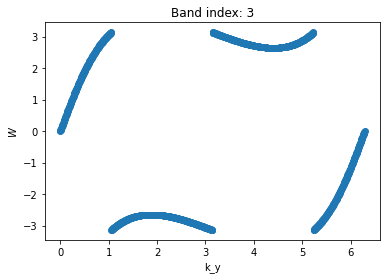

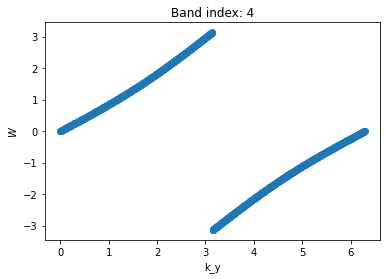

In [120]:
#Wilson loop in the x direction
def berry_phase(a, x, y):
    psi_0 = eigenvectors_arr[a, (x) % len(k_x), y % len(k_y), :]
    psi_1 = eigenvectors_arr[a, (x+1) % len(k_x), (y) % len(k_y), :]

    theta_01 = np.vdot(psi_0, psi_1)

    return theta_01
    
def wilson_loop_one(a, yi):
    product = 1
    for xi in range(len(k_x)):
        product *= berry_phase(a, xi, yi)
    wilson_output = -1*np.imag(np.log((product)))
    return wilson_output

for a in range(q):
    arr = np.empty(len(k_y))
    for i in range(len(k_y)):
        arr[i] = wilson_loop_one(a, i)
    plt.figure()
    plt.xlabel('k_y')
    plt.title('Band index: {}'.format(a))
    plt.ylabel(r'$W$')
    plt.scatter(k_y, arr)